<a href="https://colab.research.google.com/github/jefersonmglh/Formula-1_data_analyses/blob/main/1950-2018%20f1%20data%20analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author** : Jeferson Magalhães dos Santos

* **[e-mail](mailto:jefersonmdossantos@gmail.com)**
* **[github](https://github.com/jefersonmglh)**

#  <a name="indice">  Index </a>

* [Summary](#resumo)
* [1. Packages imports](#1)
* [2. Data loading](#2)
  * [2.1 Preliminary analysis](#2.1)
  * [2.2 Features engineering](#2.2)
  * [2.3 Features description](#2.3)
* [3. Exploratory Analysis](#3)
  * [3.1 UniVar](#3.1)
  * [3.2 BiVar](#3.2)
  * [3.3 MultiVar](#3.3)  
  * [3.4 Correlação e Associação](#3.4)
* [4. Modelagem](#4)
  * [4.1 Pré-processamento](#4.1)
  * [4.2 Aplicações](#4.2)
* [5. Avaliação](#5)
* [6. Aprimoramento do modelo](#6)
* [7. Conclusão](#7)

#  <a name="resumo"> Summary </a>
[Back to index](#indice)

This notebook explores all the Formula 1 data from 1950 (the inaugural season) from 2018. 
The main objectives investing this data are:
* Improvement of data engineering, analyses and plotting skills
* How the Formula 1 changed over the years?
* What are the most drivers/constructors successfull throughout the history of Formula 1?
* How race speed changed over the years?
* Do certain teams perform better on fast tracks vs. technical tracks?

#  <a name="1">1. Packages imports </a>
[Back to index](#indice)

In [1]:
#basic
import pandas as pd
import numpy as np
np.random.seed(0)

#graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette('Set2')
sns.color_palette("Set2")
import missingno as msno

#function to add labels on graphs
def addlabels(x,y, ha='center'):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = ha)

#colab
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Colab Notebooks/f1_project/datasets'

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


#  <a name="2">2. Data loading</a>
[Back to index](#indice)

In [2]:
#reading csv files
df_results = pd.read_csv(f'{PATH}/results.csv', names = ['result_id', 'race_id', 'driver_id', 'constructor_id', 'number', 'grid', 'position','position_text','position_order', 'points', 'laps','time','milliseconds','fastest_lap','rank','fastest_lap_time','fastest_lap_speed','status_id'], header=None)
df_races = pd.read_csv(f'{PATH}/races.csv', names = ['race_id', 'year', 'round','circuit_id', 'name','date','time','url'],header=None)
df_drivers = pd.read_csv(f'{PATH}/driver.csv', names = ['driver_id','driver_ref','number','code','forename','surname','dob','nationality','url'], header = None)
df_constructors = pd.read_csv(f'{PATH}/constructors.csv', names = ['constructor_id','constructor_ref','name','nationality','url'], header=None)

#merging in one df
df = pd.merge(df_results,df_races[['race_id','year', 'name','round']],on='race_id', how='left')
df = pd.merge(df,df_drivers[['driver_id','driver_ref', 'nationality', 'code', 'dob']],on='driver_id', how='left')
df = pd.merge(df,df_constructors[['constructor_id', 'constructor_ref','name','nationality']],on='constructor_id', how='left')


#cleaning and renaming some columns
df = df.drop(columns=[
    'number', 'position', 'status_id', 'result_id','race_id','driver_id','constructor_id', 'milliseconds', 'constructor_ref', 'position_text'
])

df = df.rename(columns={
    'grid': 'qualy_grid', 
    'position_order': 'final_position',
    'laps': 'laps_completed',
    'time': 'final_time',
    'fastest_lap': 'fastest_on_lap',
    'rank': 'fastest_lap_rank',
    'year': 'race_year',
    'name_x': 'race_name',
    'round': 'race_round',
    'nationality_x': 'driver_nationality',
    'code': 'driver_code',
    'dob': 'driver_dob',
    'constructor_ref': 'constructor_name',
    'name_y': 'constructor_ref',
    'nationality_y': 'constructor_nationality'
})

# rearrange columns
df = df[['race_year', 'race_name', 'race_round', 'driver_code', 
         'driver_ref', 'driver_nationality', 'driver_dob', 
         'constructor_ref', 'constructor_nationality', 'qualy_grid', 'final_position', 'points', 
         'laps_completed', 'final_time', 'fastest_on_lap', 'fastest_lap_rank',
         'fastest_lap_time', 'fastest_lap_speed']]

#sorting by columns
df = df.sort_values(by=['race_year', 'race_round', 'final_position'])

#reset index
df = df.reset_index(drop = True)


In [3]:
df.head()

,race_year,race_name,race_round,driver_code,driver_ref,driver_nationality,driver_dob,constructor_ref,constructor_nationality,qualy_grid,final_position,points,laps_completed,final_time,fastest_on_lap,fastest_lap_rank,fastest_lap_time,fastest_lap_speed
0,1950,British Grand Prix,1,\N,farina,Italian,1906-10-30,Alfa Romeo,Italian,1,1,9.0,70,2:13:23.6,\N,\N,\N,\N
1,1950,British Grand Prix,1,\N,fagioli,Italian,1898-06-09,Alfa Romeo,Italian,2,2,6.0,70,+2.6,\N,\N,\N,\N
2,1950,British Grand Prix,1,\N,reg_parnell,British,1911-07-02,Alfa Romeo,Italian,4,3,4.0,70,+52.0,\N,\N,\N,\N
3,1950,British Grand Prix,1,\N,cabantous,French,1904-10-08,Talbot-Lago,French,6,4,3.0,68,\N,\N,\N,\N,\N
4,1950,British Grand Prix,1,\N,rosier,French,1905-11-05,Talbot-Lago,French,9,5,2.0,68,\N,\N,\N,\N,\N


In [4]:
#saving the merged data in csv format
df.to_csv(f'{PATH}/merged_data.csv', index=False)

> ####  <a name="2.1">2.1 Preliminary analyses</a>
[Back to index](#indice)

In [5]:
def show_info(data):
    print('DATASET SHAPE: ', data.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(data.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(data.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(data.isnull().sum())

print('SET INFO')
show_info(df)

SET INFO
DATASET SHAPE:  (24217, 18) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24217 entries, 0 to 24216
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   race_year                24217 non-null  int64  
 1   race_name                24217 non-null  object 
 2   race_round               24217 non-null  int64  
 3   driver_code              24217 non-null  object 
 4   driver_ref               24217 non-null  object 
 5   driver_nationality       24217 non-null  object 
 6   driver_dob               24217 non-null  object 
 7   constructor_ref          24217 non-null  object 
 8   constructor_nationality  24217 non-null  object 
 9   qualy_grid               24217 non-null  int64  
 10  final_position           24217 non-null  int64  
 11  points                   24217 non-null  float64
 12  laps_completed      

A little bit strange a dataset with 0 non null values.
Let's check if this information is true.

In [6]:
def top_unique_values(df):
    top_3 = pd.DataFrame()
    for col in df.columns:
        top_3[col] = df[col].value_counts().nlargest(3).index.tolist()
    
    return top_3


In [7]:
top_unique_values(df)

,race_year,race_name,race_round,driver_code,driver_ref,driver_nationality,driver_dob,constructor_ref,constructor_nationality,qualy_grid,final_position,points,laps_completed,final_time,fastest_on_lap,fastest_lap_rank,fastest_lap_time,fastest_lap_speed
0,1989,British Grand Prix,2,\N,barrichello,British,1972-05-23,Ferrari,British,0,3,0.0,0,\N,\N,\N,\N,\N
1,1990,Italian Grand Prix,6,BAR,alonso,Italian,1981-07-29,McLaren,Italian,7,4,2.0,70,+8:22.19,50,1,1:18.262,213.224
2,1991,German Grand Prix,7,ALO,button,French,1980-01-19,Williams,French,1,2,4.0,53,+46.2,52,2,1:18.462,195.933


Analyzing the head and to top unique values we can see that the null values are related to '/N' string. Let's change that.

In [8]:
df = df.replace('\\N', np.nan)


In [9]:
show_info(df)

DATASET SHAPE:  (24217, 18) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24217 entries, 0 to 24216
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   race_year                24217 non-null  int64  
 1   race_name                24217 non-null  object 
 2   race_round               24217 non-null  int64  
 3   driver_code              7639 non-null   object 
 4   driver_ref               24217 non-null  object 
 5   driver_nationality       24217 non-null  object 
 6   driver_dob               24216 non-null  object 
 7   constructor_ref          24217 non-null  object 
 8   constructor_nationality  24217 non-null  object 
 9   qualy_grid               24217 non-null  int64  
 10  final_position           24217 non-null  int64  
 11  points                   24217 non-null  float64
 12  laps_completed           2421

Text(0.5, 1.0, 'MISSING VALUES')

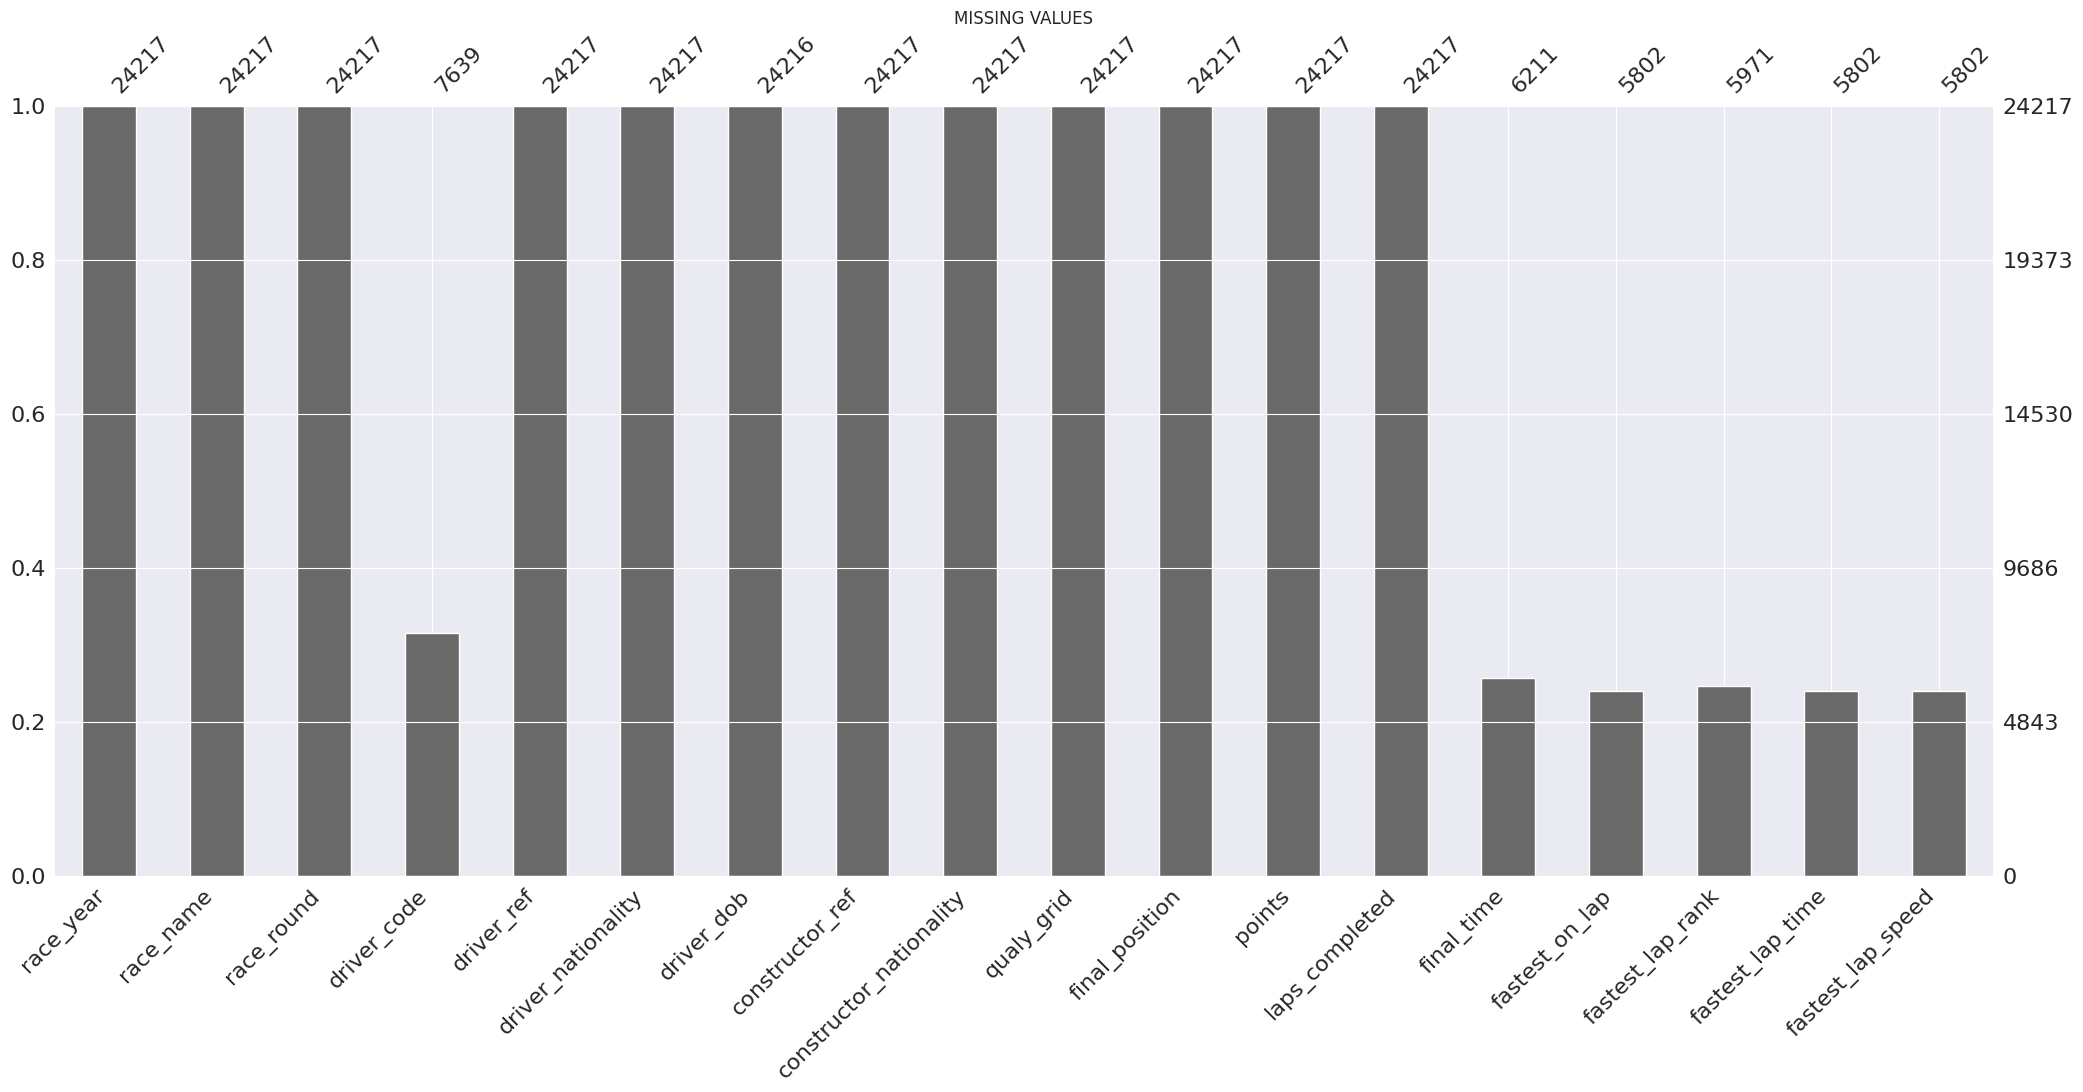

In [10]:
null_bar_graph = msno.bar(df)
null_bar_graph.set_title('MISSING VALUES')

In [11]:
print('QUANTITATIVE FEATURES INFO')
df.describe()

QUANTITATIVE FEATURES INFO


,race_year,race_round,qualy_grid,final_position,points,laps_completed
count,24217.000000,24217.000000,24217.000000,24217.000000,24217.000000,24217.000000
mean,1988.226865,8.213032,11.255482,13.034686,1.664102,45.409547
std,18.264381,4.830442,7.321633,7.799787,3.786581,30.364668
min,1950.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,1975.000000,4.000000,5.000000,7.000000,0.000000,20.000000
50%,1989.000000,8.000000,11.000000,13.000000,0.000000,52.000000
75%,2004.000000,12.000000,17.000000,19.000000,1.000000,66.000000
max,2019.000000,21.000000,34.000000,39.000000,50.000000,200.000000


In [12]:
df.head()

,race_year,race_name,race_round,driver_code,driver_ref,driver_nationality,driver_dob,constructor_ref,constructor_nationality,qualy_grid,final_position,points,laps_completed,final_time,fastest_on_lap,fastest_lap_rank,fastest_lap_time,fastest_lap_speed
0,1950,British Grand Prix,1,NaN,farina,Italian,1906-10-30,Alfa Romeo,Italian,1,1,9.0,70,2:13:23.6,NaN,NaN,NaN,NaN
1,1950,British Grand Prix,1,NaN,fagioli,Italian,1898-06-09,Alfa Romeo,Italian,2,2,6.0,70,+2.6,NaN,NaN,NaN,NaN
2,1950,British Grand Prix,1,NaN,reg_parnell,British,1911-07-02,Alfa Romeo,Italian,4,3,4.0,70,+52.0,NaN,NaN,NaN,NaN
3,1950,British Grand Prix,1,NaN,cabantous,French,1904-10-08,Talbot-Lago,French,6,4,3.0,68,NaN,NaN,NaN,NaN,NaN
4,1950,British Grand Prix,1,NaN,rosier,French,1905-11-05,Talbot-Lago,French,9,5,2.0,68,NaN,NaN,NaN,NaN,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24217 entries, 0 to 24216
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   race_year                24217 non-null  int64  
 1   race_name                24217 non-null  object 
 2   race_round               24217 non-null  int64  
 3   driver_code              7639 non-null   object 
 4   driver_ref               24217 non-null  object 
 5   driver_nationality       24217 non-null  object 
 6   driver_dob               24216 non-null  object 
 7   constructor_ref          24217 non-null  object 
 8   constructor_nationality  24217 non-null  object 
 9   qualy_grid               24217 non-null  int64  
 10  final_position           24217 non-null  int64  
 11  points                   24217 non-null  float64
 12  laps_completed           24217 non-null  int64  
 13  final_time               6211 non-null   object 
 14  fastest_on_lap        

####  <a name="2.2">2.2 Features engineering</a>
[Back to index](#indice)

The feature 'driver_code' has too many null values. 

In [14]:
df = df.drop(columns=['driver_code'])

Check the number of rounds in each year.

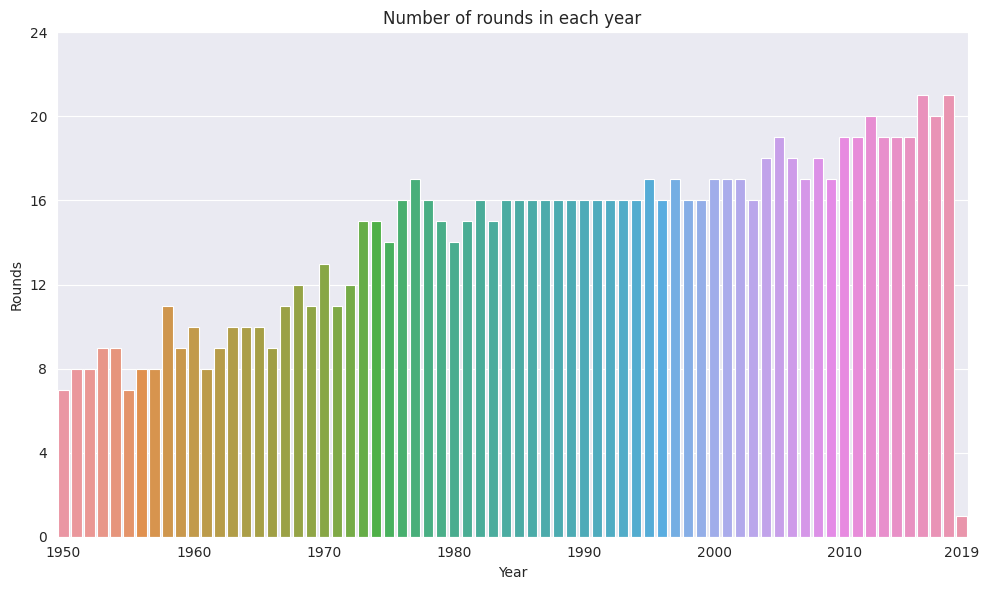

In [15]:
t = df.groupby('race_year')['race_round'].max()

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(y = t, x = t.index,
           linewidth=.8, ax=ax)
plt.title('Number of rounds in each year')
plt.ylabel('Rounds')
plt.xlabel('Year')

ax.set_xticks([0,10,20,30,40,50,60,69])

ax.set_yticks([0,4,8,12,16,20,24])
# ax.set_xlim([n for n in range(1950,2020) if n % 10 == 0 or n == 2019])

plt.tight_layout()

We can see that in the 2019 season we only have 1 round registred. For that reason we are going to discard that year from our dataset.

In [16]:
df = df[df['race_year'] != 2019]
df.shape

(24197, 17)

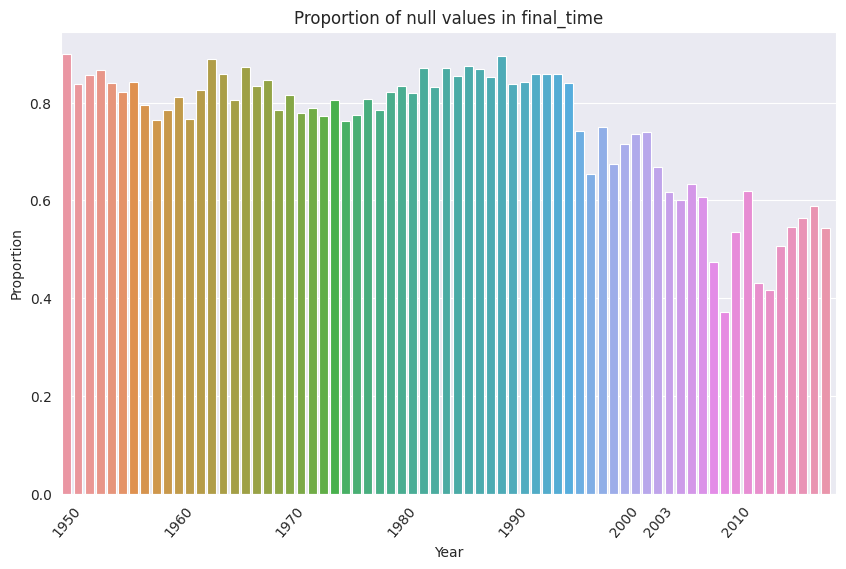

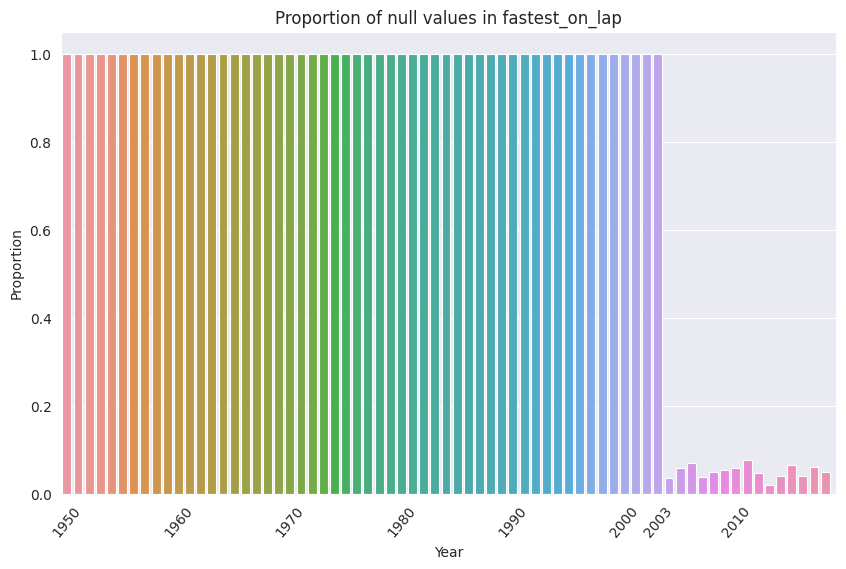

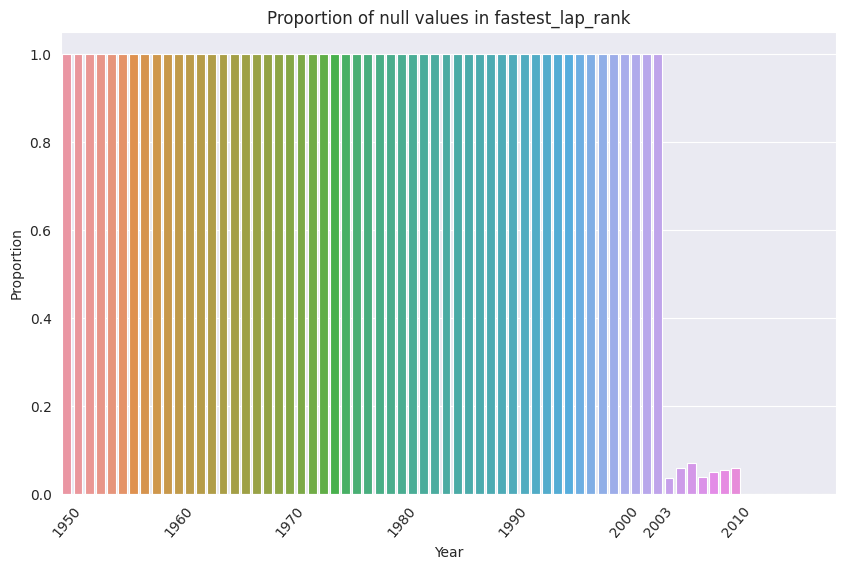

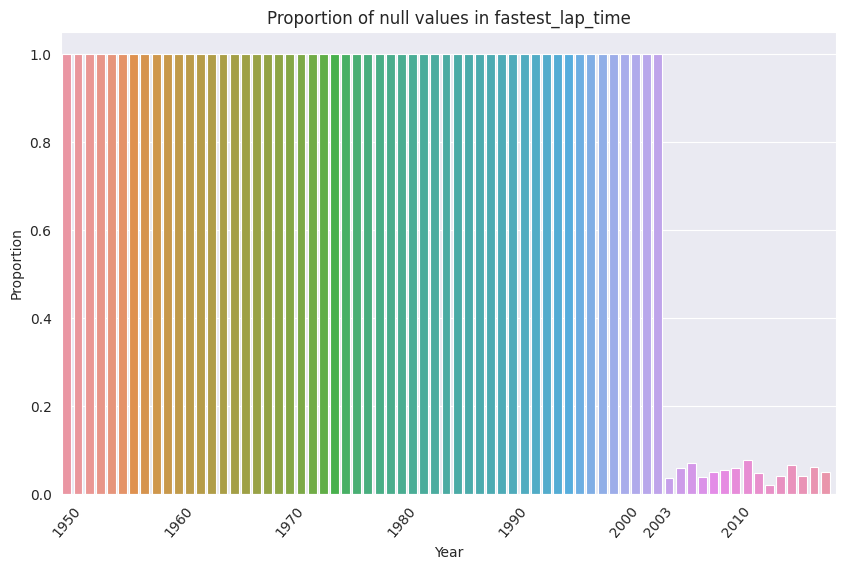

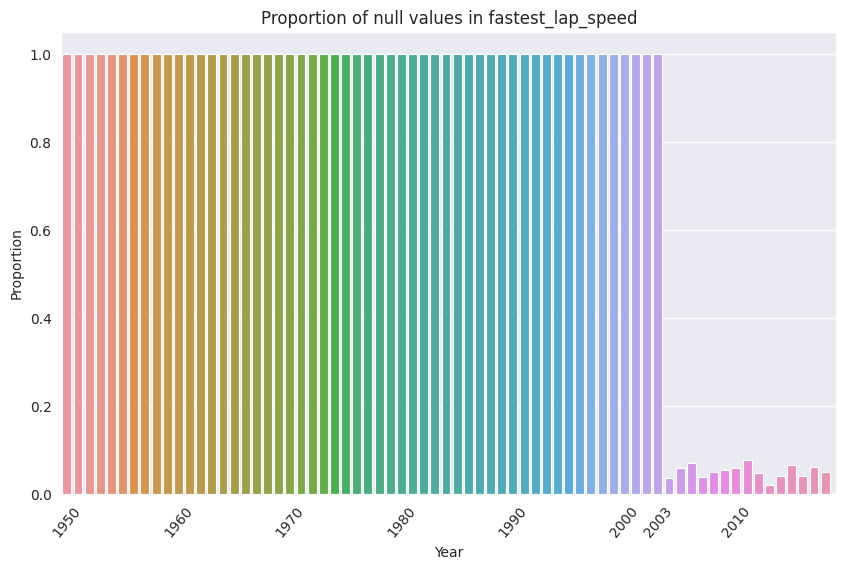

In [17]:
features_null_values = ['final_time', 'fastest_on_lap', 'fastest_lap_rank',
       'fastest_lap_time', 'fastest_lap_speed']

for feature in features_null_values:
  all_values_per_year = df.groupby('race_year')['race_name'].count()
  null_values_per_year = df.groupby('race_year')[feature].apply(lambda x: x.isnull().sum())

  proportion = [x / y for x, y in zip(null_values_per_year, all_values_per_year)]

  fig, ax = plt.subplots(figsize=(10, 6))
  sns.barplot(y = proportion, x = df.race_year.unique(),
           linewidth=.8, ax=ax)
  

  ax.set_xticks([0,10,20,30,40,50,53,60,69])

  
  plt.xticks(rotation=50)
  plt.title(f'Proportion of null values in {feature}')
  plt.ylabel('Proportion')
  plt.xlabel('Year')



We can check in graphical above that:
* 'final_time' has a lot of null_values not following a pattern
* 'fastest_lap_rank', 'fastest_lap_speed', 'fastest_lap_time' are only avaiable before year 2003.


Having said that, we conclude that it would be better to exclude the 'final_time' feature.


In [18]:
df = df.drop(columns=['final_time'])

Below we made some data type convertions

In [19]:
df = df.astype({'fastest_on_lap': 'float64',
 'fastest_lap_rank': 'float64',
 'fastest_lap_speed': 'float64'})

df['fastest_lap_time'] = pd.to_timedelta('00:' + df['fastest_lap_time'])

df['driver_dob'] = pd.to_datetime(df['driver_dob'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24197 entries, 0 to 24196
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   race_year                24197 non-null  int64          
 1   race_name                24197 non-null  object         
 2   race_round               24197 non-null  int64          
 3   driver_ref               24197 non-null  object         
 4   driver_nationality       24197 non-null  object         
 5   driver_dob               24196 non-null  datetime64[ns] 
 6   constructor_ref          24197 non-null  object         
 7   constructor_nationality  24197 non-null  object         
 8   qualy_grid               24197 non-null  int64          
 9   final_position           24197 non-null  int64          
 10  points                   24197 non-null  float64        
 11  laps_completed           24197 non-null  int64          
 12  fastest_on_lap    

####  <a name="2.3">2.3 Features description</a>
[Back to index](#indice)

##### **Dataset structure**

The dataset includes data from 1950 to 2019 of grand prix results, drivers, constructors, circuits and lap times. There are 19 features:

* **race_year:** year/season that Grand Prix happened
* **race_name:**  name of the Grand Prix
* **race_round:** sequential number of that race in that season
* **driver_code:** 3 letters code used by the driver
* **driver_ref:** driver's name
* **driver_nationality:** country where that drivers born 
* **driver_dob:** driver's date of birth
* **constructor_ref:** name of the car constructor
* **constructor_nationality:** country where the constructor is based
* **qualy_grid:** starting position earned in qualification
* **final_position:** final position at the end of the Grand Prix
* **points:** points earned in the Grand Prix
* **laps_completed:** total laps completed in the Grand Prix
* **final_time:** the amount of time that took to finish the race. 
* **fastest_on_lap:** lap where the fastest lap was got
* **fastest_lap_rank:** order of the fastest lap in a race
* **fastest_lap_time:** fastest lap time
* **fastest_lap_speed:** average speed of the fastest lap

#  <a name="3">3. Exploratory Analyses</a>
[Back to index](#indice)

> ####  <a name="3.1">3.1 UniVar</a>
[Back to index](#indice)

* Who are the most sucessfull drivers in Formula 1 history?

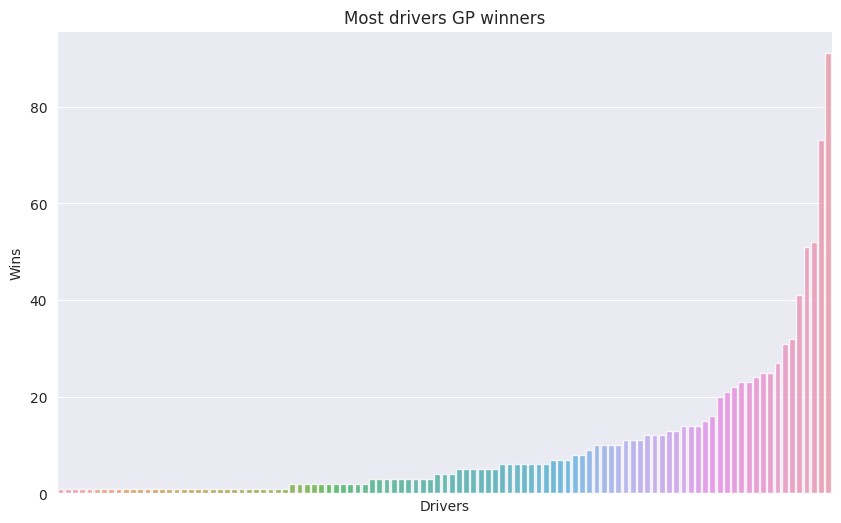

In [21]:
df_drivers_winners = df[df['final_position'] == 1].groupby('driver_ref')['final_position'].count().sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_drivers_winners.index, y=df_drivers_winners, alpha=0.8, ax=ax)

plt.title('Most drivers GP winners')
plt.xlabel('Drivers')
plt.ylabel('Wins')
plt.xticks([])

plt.show()

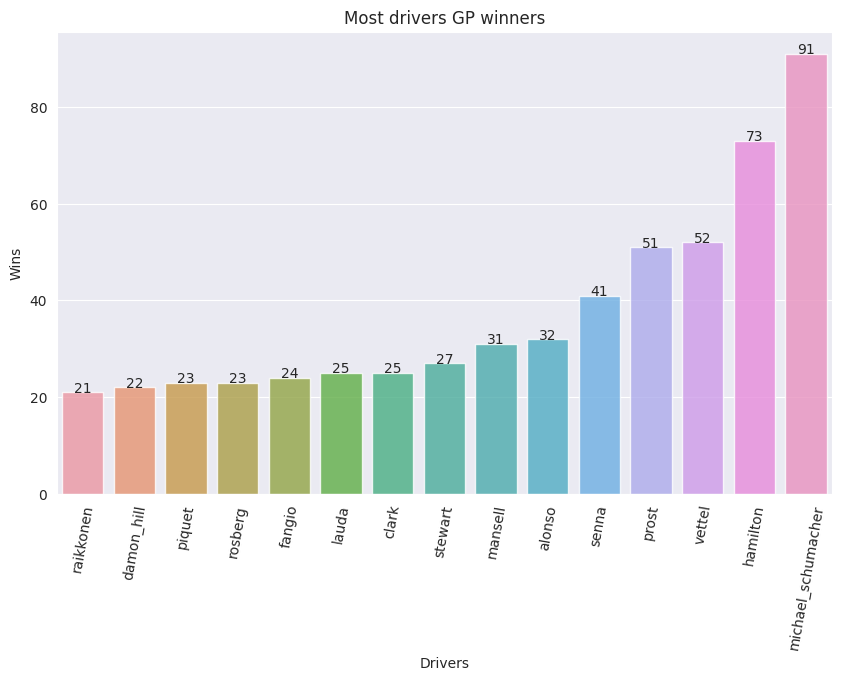

In [22]:
df_20_wins = df_drivers_winners[df_drivers_winners > 20]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_20_wins.index, y=df_20_wins, alpha=0.8, ax=ax)

plt.title('Most drivers GP winners')
plt.xlabel('Drivers')
plt.ylabel('Wins')

addlabels(x=df_20_wins.index, y=df_20_wins)
plt.xticks(rotation=80)
plt.show()

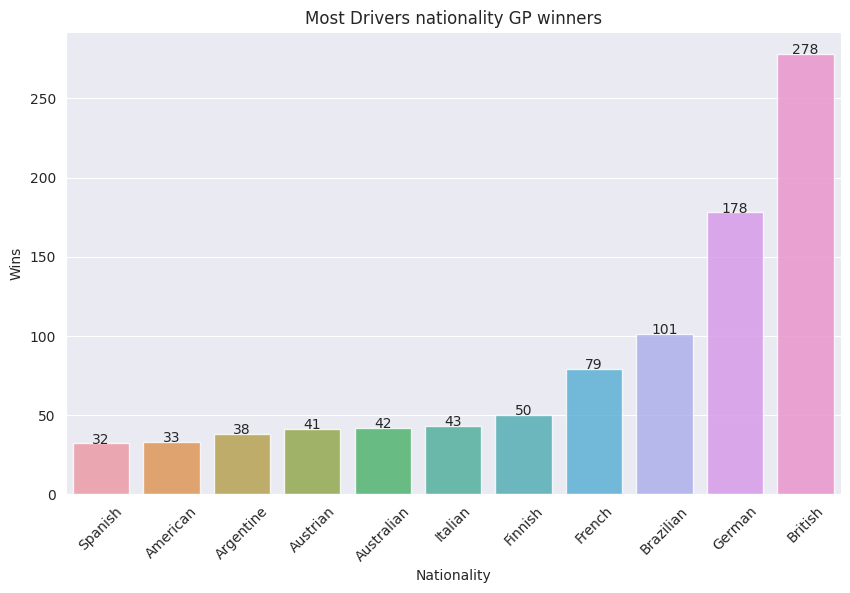

In [23]:
df_driver_nat_winners = df[df['final_position'] == 1].groupby('driver_nationality')['final_position'].count().sort_values()
df_driver_nat_winners = df_driver_nat_winners[df_driver_nat_winners > 20]


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_driver_nat_winners.index, y=df_driver_nat_winners, alpha=0.8, ax=ax)

plt.title('Most Drivers nationality GP winners')
plt.xlabel('Nationality')
plt.ylabel('Wins')

addlabels(x=df_driver_nat_winners.index, y=df_driver_nat_winners)
plt.xticks(rotation=45)
plt.show()

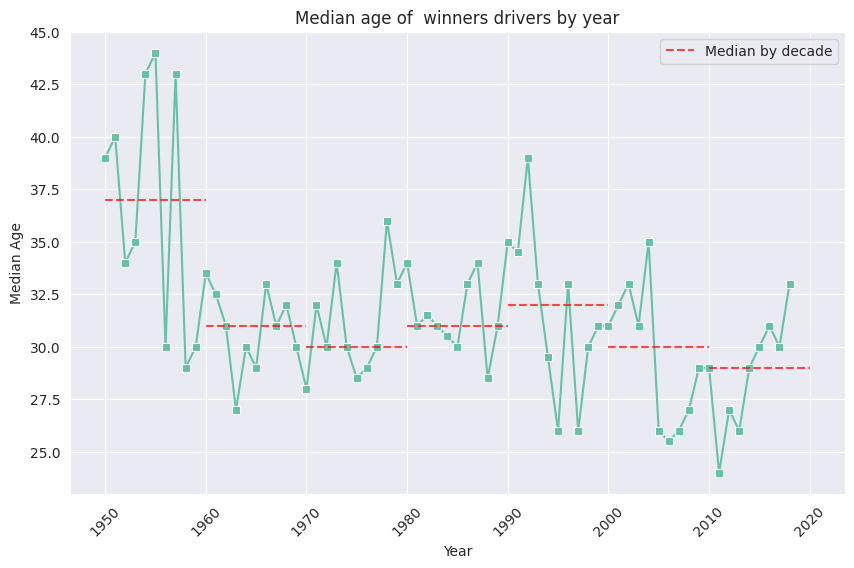

In [24]:
df['driver_age'] = df['race_year'] - pd.DatetimeIndex(df['driver_dob']).year
df_drivers_dob_median = df[df['final_position'] == 1].groupby('race_year')['driver_age'].median()


df_drivers_dob_median.index = pd.to_datetime(df_drivers_dob_median.index, format='%Y')


#calculating medians of medians
median_of_medians = {'range_year': [],
           'median': []}
for i, v in df_drivers_dob_median.items():
  if i.year % 10 == 0:
    dt_plus_10y = i + pd.DateOffset(years=10)
    df_x = df_drivers_dob_median[(df_drivers_dob_median.index >= i) & (df_drivers_dob_median.index < dt_plus_10y)]
    md = df_x.median()

    median_of_medians['range_year'].append(i)
    median_of_medians['median'].append(md)

df_md_of_md = pd.DataFrame(data=median_of_medians, index=median_of_medians['range_year'])
df_md_of_md = df_md_of_md.drop(columns=['range_year'])

    


fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=df_drivers_dob_median.index.year.astype(int), y=df_drivers_dob_median, marker='s', ax=ax)
for ind, v in df_md_of_md['median'].items():
    if ind.year == 1950:
      dt_plus_10y = ind + pd.DateOffset(years=10)
      ax.plot([ind.year, dt_plus_10y.year], [v, v], color='red', linestyle='--', alpha = 0.7, label='Median by decade')
    else:
      dt_plus_10y = ind + pd.DateOffset(years=10)
      ax.plot([ind.year, dt_plus_10y.year], [v, v], color='red', linestyle='--', alpha = 0.7)




ax.legend()
plt.title('Median age of  winners drivers by year')
plt.xlabel('Year')
plt.ylabel('Median Age')







plt.xticks(rotation=45)
plt.show()

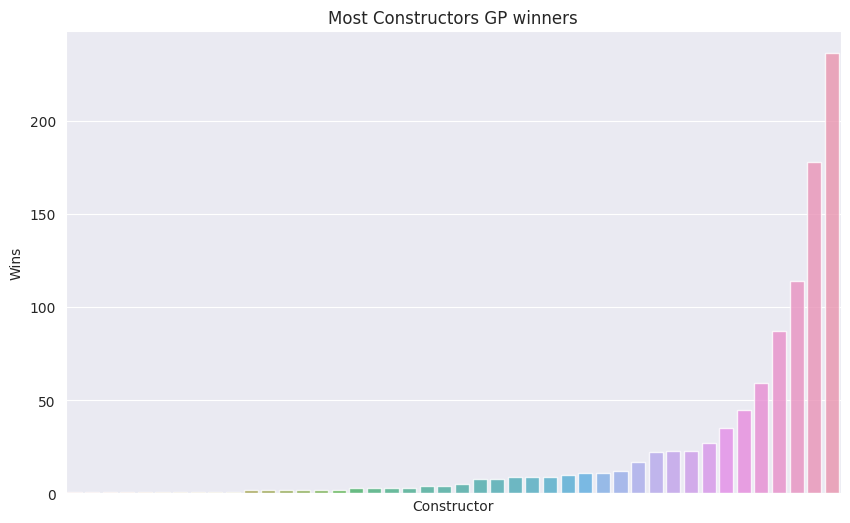

In [25]:
df_constr_wins = df[df['final_position'] == 1].groupby('constructor_ref')['final_position'].count().sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_constr_wins.index, y=df_constr_wins, alpha=0.8, ax=ax)

plt.title('Most Constructors GP winners')
plt.xlabel('Constructor')
plt.ylabel('Wins')
plt.xticks([])

plt.show()

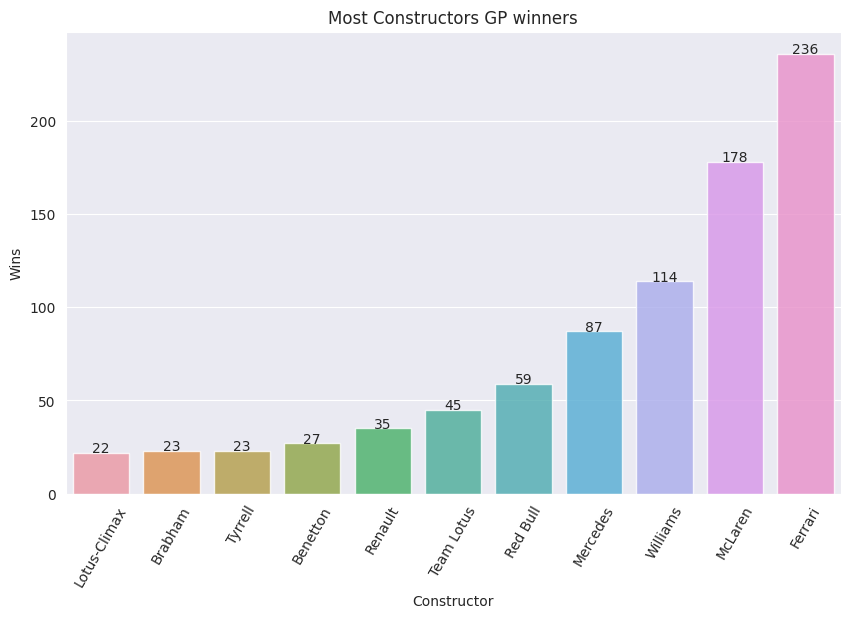

In [26]:
df_constr_top_winners = df_constr_wins[df_constr_wins>20]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_constr_top_winners.index, y=df_constr_top_winners, alpha=0.8, ax=ax)

plt.title('Most Constructors GP winners')
plt.xlabel('Constructor')
plt.ylabel('Wins')
plt.xticks(rotation=60)
addlabels(x = df_constr_top_winners.index, y=df_constr_top_winners)
plt.show()

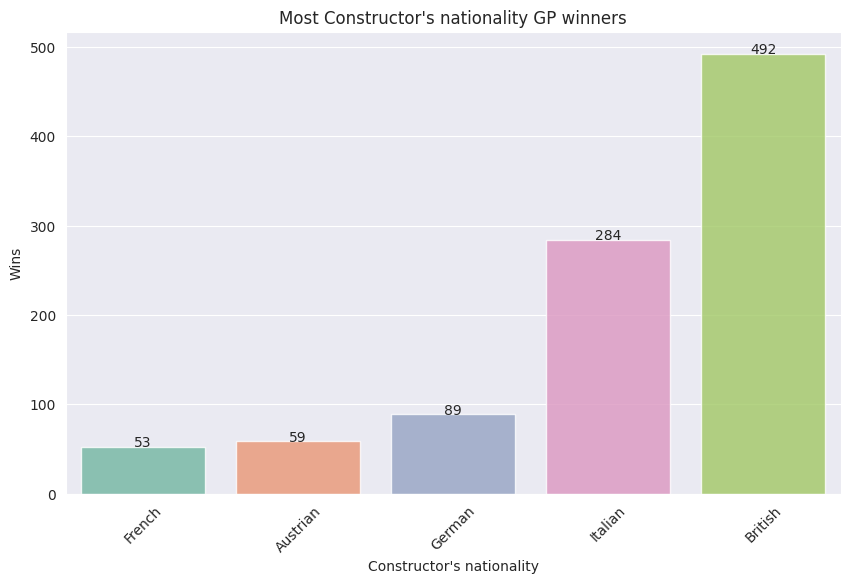

In [27]:
df_constr_top_nat = df[df['final_position'] == 1].groupby('constructor_nationality')['final_position'].count().sort_values()
df_constr_top_nat = df_constr_top_nat[df_constr_top_nat > 20]


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_constr_top_nat.index, y=df_constr_top_nat, alpha=0.8, ax=ax)

plt.title("Most Constructor's nationality GP winners")
plt.xlabel("Constructor's nationality")
plt.ylabel('Wins')

addlabels(x=df_constr_top_nat.index, y=df_constr_top_nat)
plt.xticks(rotation=45)
plt.show()

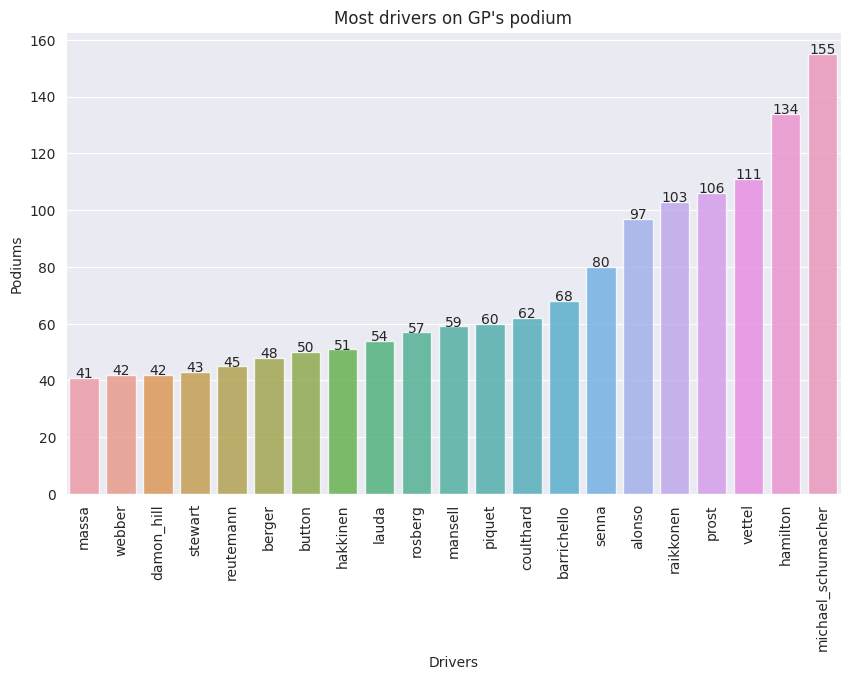

In [28]:
df_drivers_podium = df[df['final_position'] <= 3].groupby('driver_ref')['final_position'].count().sort_values()
df_drivers_podium = df_drivers_podium[df_drivers_podium > 40]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_drivers_podium.index, y=df_drivers_podium, alpha=0.8, ax=ax)


plt.title("Most drivers on GP's podium")
plt.xlabel("Drivers")
plt.ylabel('Podiums')


addlabels(x=df_drivers_podium.index, y=df_drivers_podium)
plt.xticks(rotation=90)
plt.show()

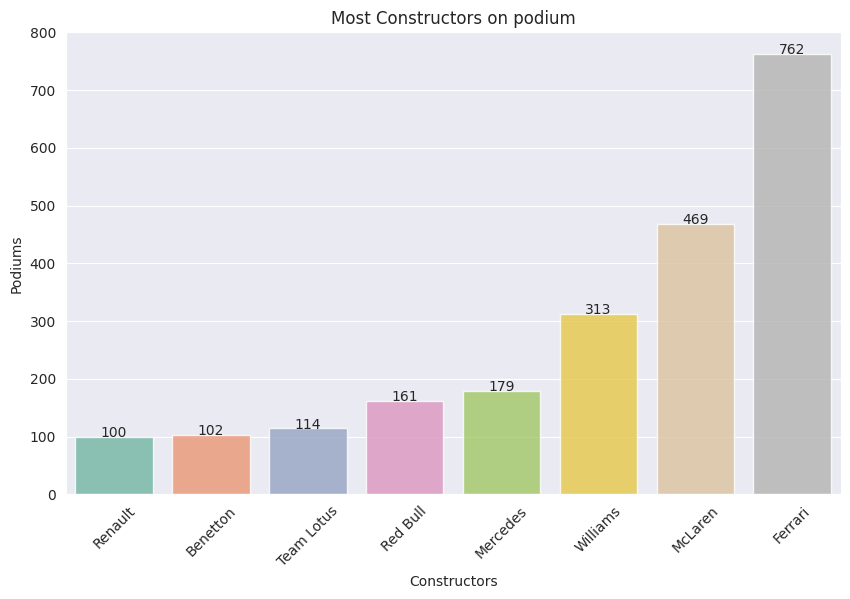

In [29]:
df_construc_podiums = df[df['final_position'] <= 3].groupby('constructor_ref')['final_position'].count().sort_values()
df_construc_podiums = df_construc_podiums[df_construc_podiums >= 100]


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_construc_podiums.index, y=df_construc_podiums, alpha=0.8, ax=ax)

plt.title("Most Constructors on podium")
plt.xlabel("Constructors")
plt.ylabel('Podiums')

addlabels(x=df_construc_podiums.index, y=df_construc_podiums)
plt.xticks(rotation=45)
plt.show()

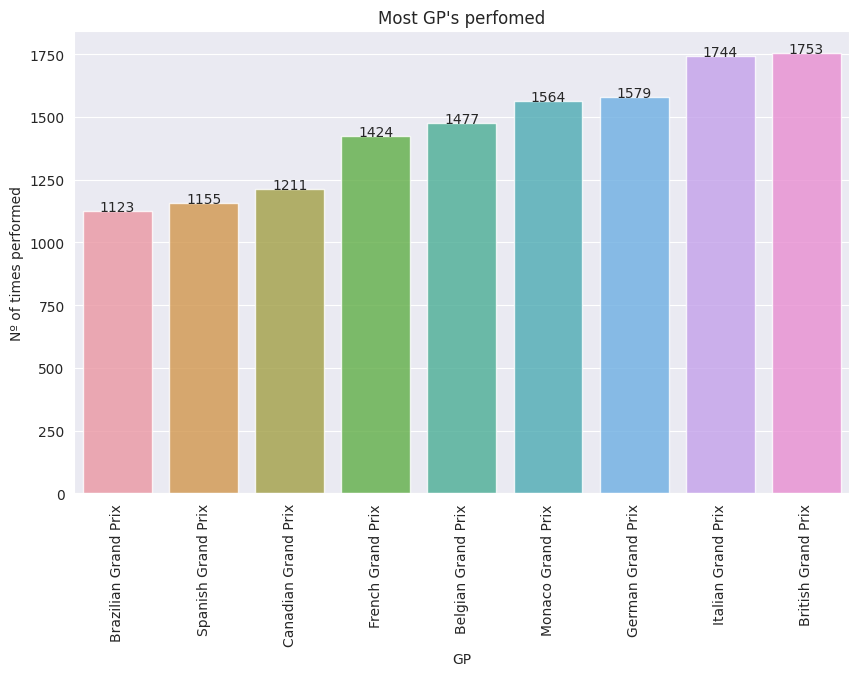

In [30]:
df_top_gps=df.groupby('race_name')['final_position'].count().sort_values()
df_top_gps = df_top_gps[df_top_gps >= 1000]



fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = df_top_gps.index, y=df_top_gps, alpha=0.8, ax=ax)

plt.title('Most GP\'s perfomed')
plt.xlabel('GP')
plt.ylabel('Nº of times performed')
plt.xticks(rotation=90)
addlabels(x = df_top_gps.index, y=df_top_gps)
plt.show()

> ####  <a name="3.2">3.2 BiVar</a>
[Back to index](#indice)

Text(0.5, 0, 'Starting position')

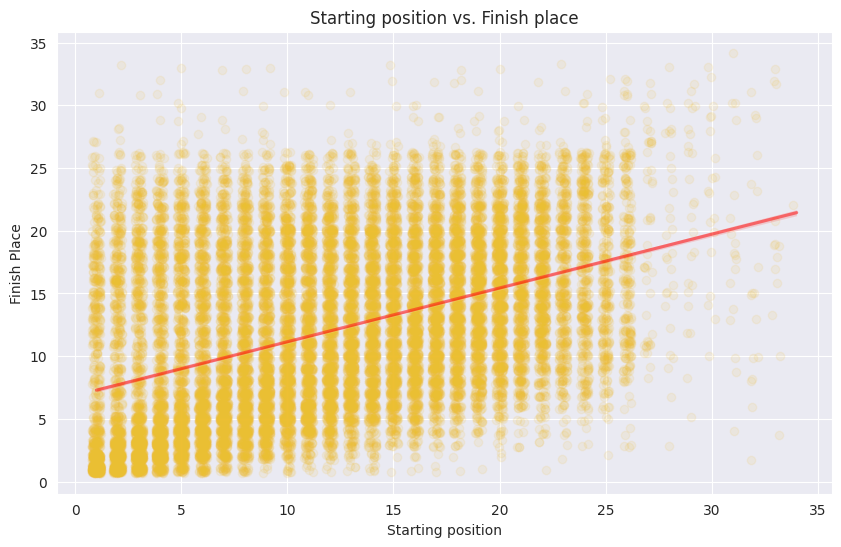

In [31]:
#0 means that the driver started from pit lane.
df_no_zero = df[df['qualy_grid'] != 0]

fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data = df_no_zero, x = 'qualy_grid', y = 'final_position', x_jitter = 0.2, y_jitter = 0.3, scatter_kws = {'alpha' : 0.1, 'color': '#edbf33'}, line_kws = {'alpha': 0.5, 'color': 'r'}, ax=ax)
plt.title('Starting position vs. Finish place')
plt.ylabel('Finish Place')
plt.xlabel('Starting position')

<Axes: xlabel='qualy_grid', ylabel='count'>

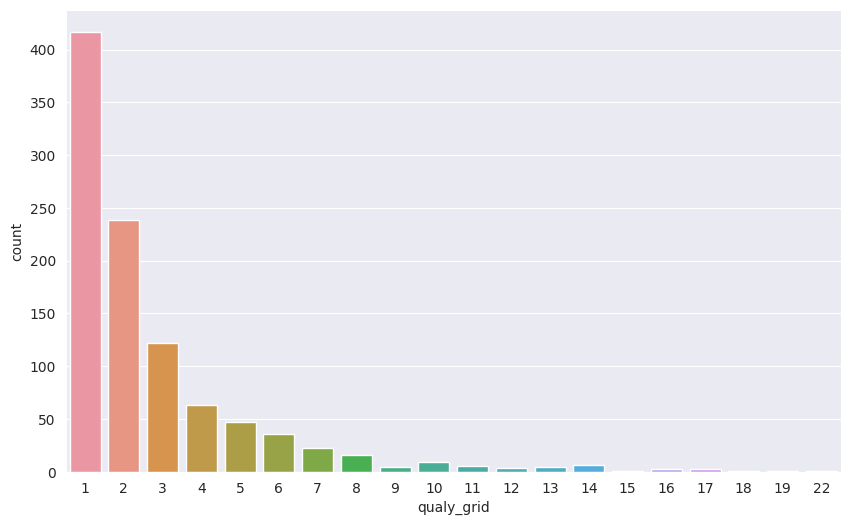

In [32]:
df_winners = df[df['final_position'] == 1]

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data=df_winners, x='qualy_grid')




drivers x circuits

drivers x construct

constructors x circuits

[] []


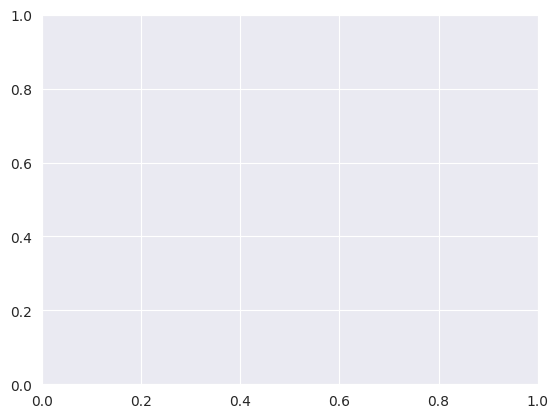

In [58]:
handles, labels = plt.gca().get_legend_handles_labels()


# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

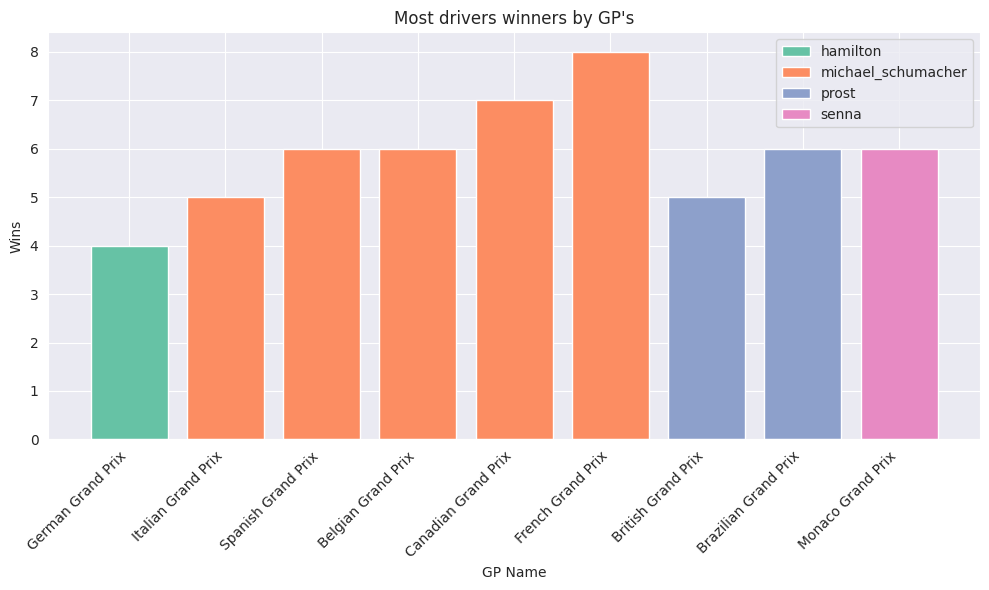

In [63]:
#drivers x constructs

data = {}
for i, r in df_top_gps.items():
  t = df[df['race_name'] == i]
  t1 = t[t['final_position'] == 1].groupby('driver_ref')['final_position'].count().sort_values()
  data[i] = (t1.index[-1], t1[-1])

data_df = pd.DataFrame.from_dict(data, orient='index', columns=['driver', 'wins'])
data_df.reset_index(inplace=True)
data_df.columns = ['gp_name', 'most_winner', 'wins']

plt.figure(figsize=(10, 6))

data_df = data_df.sort_values('wins')
groups = data_df.groupby('most_winner')

for name, group in groups:    
    plt.bar(group['gp_name'], group['wins'], label=name)

plt.xticks(rotation=45, ha='right')
plt.xlabel('GP Name')
plt.ylabel('Wins')
plt.title('Most drivers winners by GP\'s')


plt.legend()
plt.tight_layout()  

plt.show()



In [34]:
df_construc_podiums

constructor_ref
Renault       100
Benetton      102
Team Lotus    114
Red Bull      161
Mercedes      179
Williams      313
McLaren       469
Ferrari       762
Name: final_position, dtype: int64

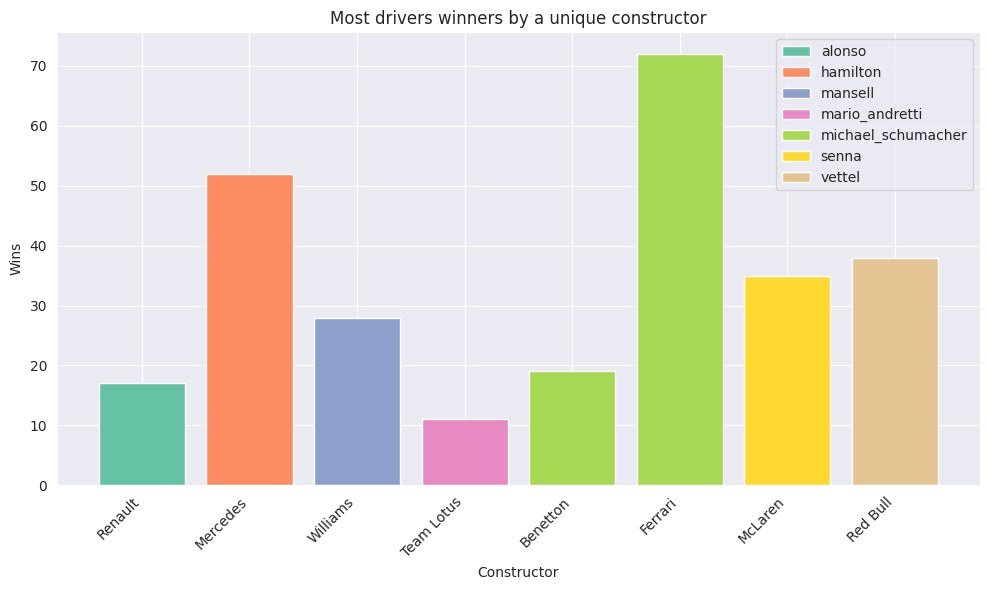

In [64]:
data = {}
for i, r in df_construc_podiums.items():
  t = df[df['constructor_ref'] == i]
  t1 = t[t['final_position'] == 1].groupby('driver_ref')['final_position'].count().sort_values()
  data[i] = (t1.index[-1], t1[-1])

data_df = pd.DataFrame.from_dict(data, orient='index', columns=['driver', 'wins'])
data_df.reset_index(inplace=True)
data_df.columns = ['constructor', 'most_winner', 'wins']

data_df = data_df.sort_values('wins')

plt.figure(figsize=(10, 6))
groups = data_df.groupby('most_winner')


for name, group in groups:    
    plt.bar(group['constructor'], group['wins'], label=name)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Constructor')
plt.ylabel('Wins')
plt.title('Most drivers winners by a unique constructor')

plt.legend()
plt.tight_layout()  

plt.show()



* Analysing how the speed changed over the years


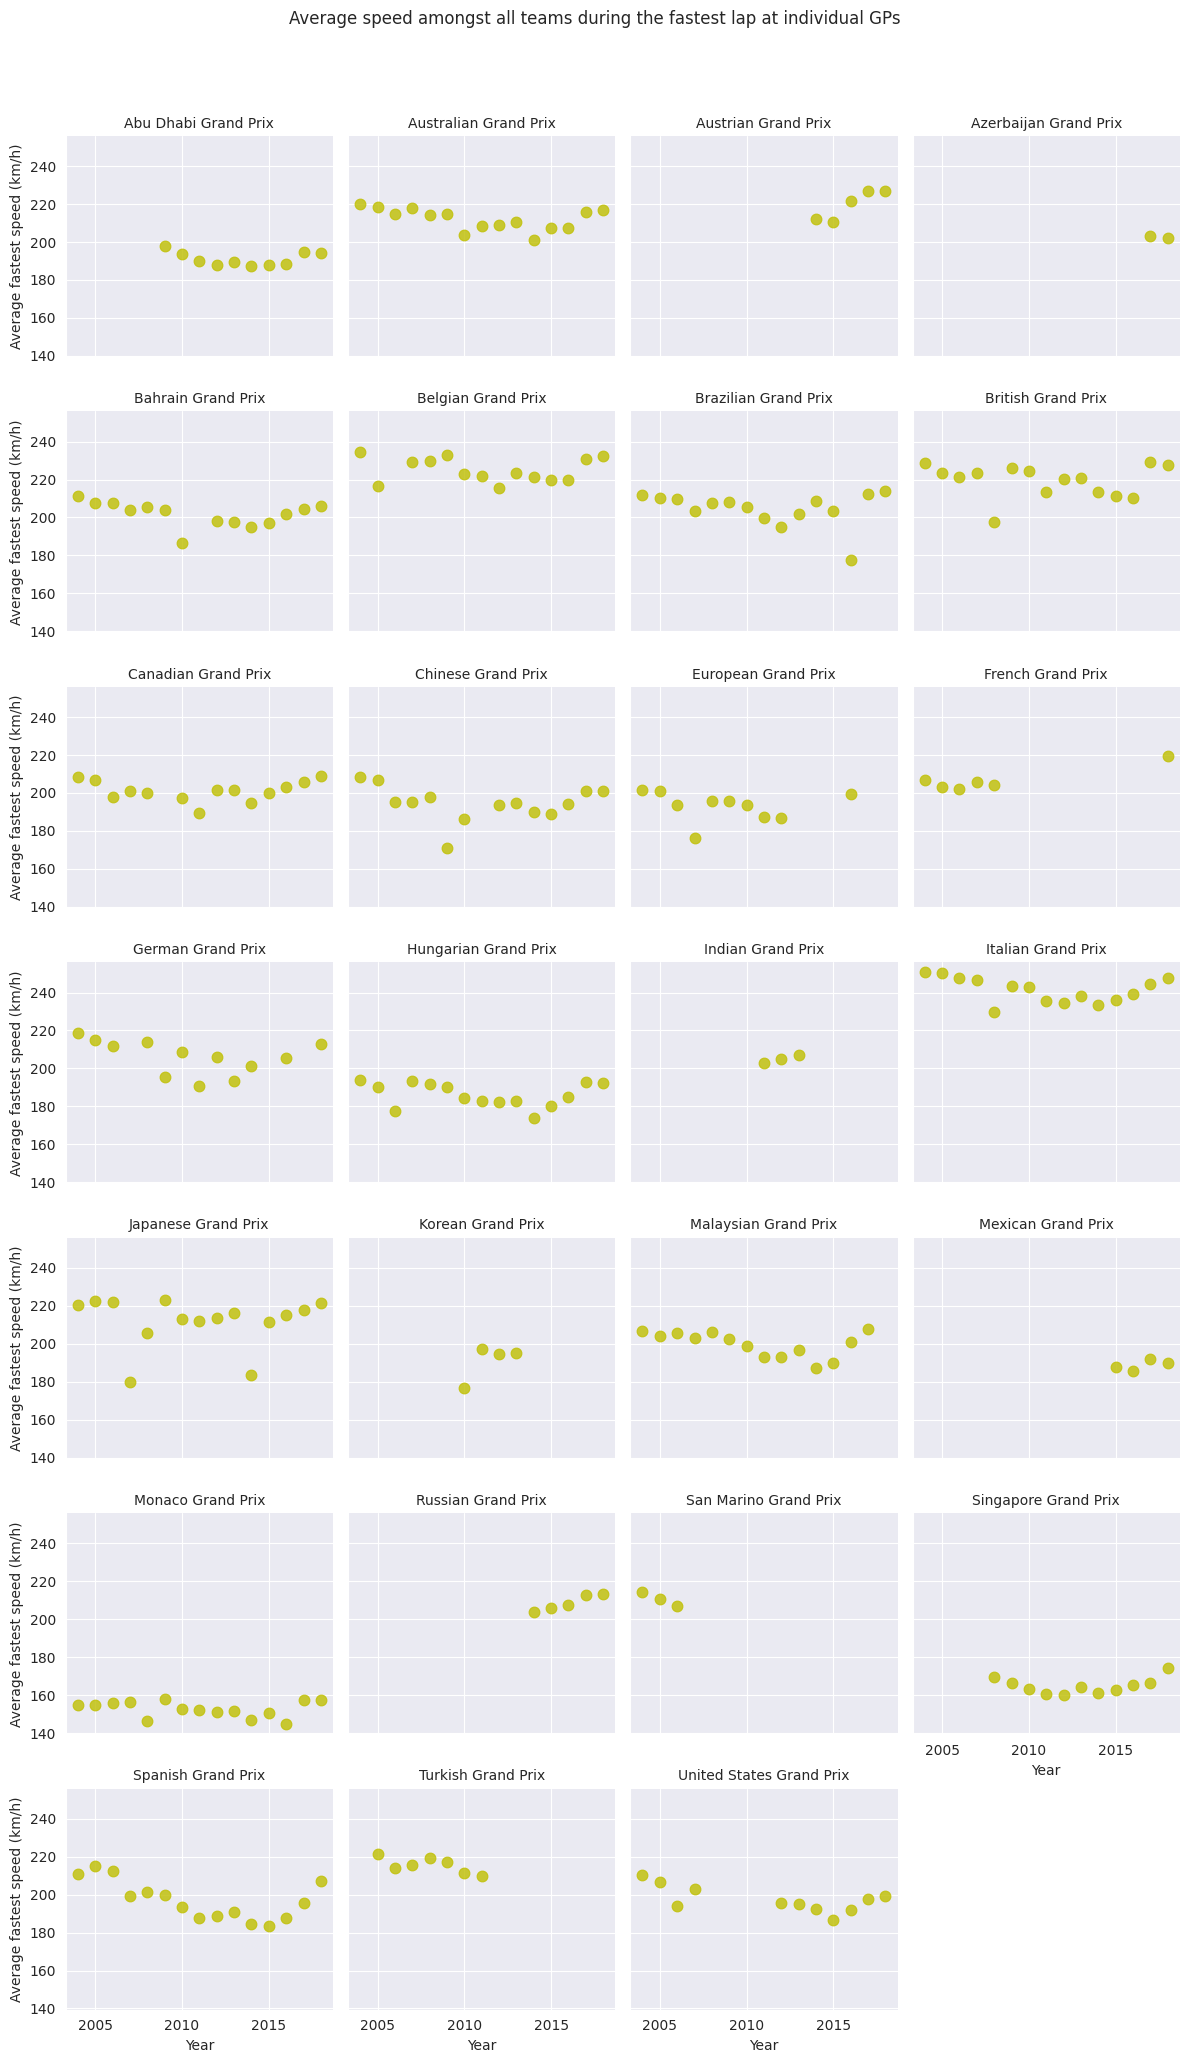

In [87]:
df_times = df[df['race_year'] >= 2004]
df_group_speed = df_times.groupby(['race_name', 'race_year'])['fastest_lap_speed'].mean().to_frame().reset_index()

g = sns.FacetGrid(data = df_group_speed, col = 'race_name', col_wrap=4)
g.map(plt.scatter, 'race_year','fastest_lap_speed', alpha = 0.8, linewidth=.8, s = 60, color='y' )
g.set_titles("{col_name}")
g.set_xlabels('Year')
g.set_ylabels('Average fastest speed (km/h)')
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Average speed amongst all teams during the fastest lap at individual GPs');
  

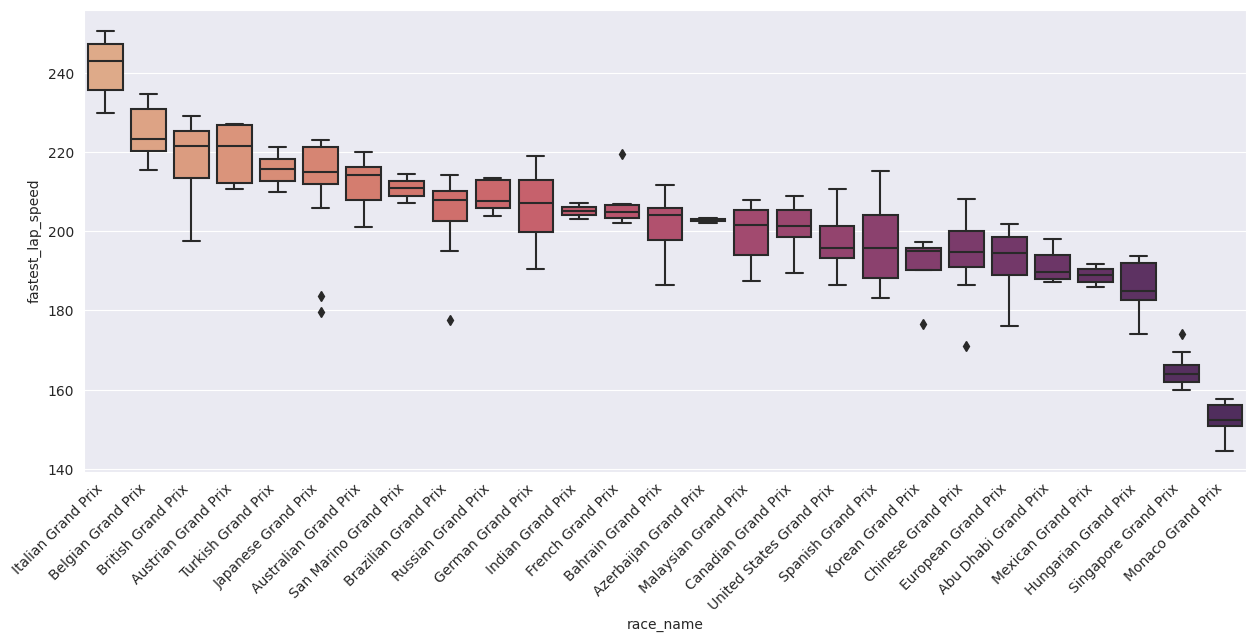

In [96]:
df_group_speed.head()
plt.figure(figsize=(15, 6))

order = df_group_speed.groupby(by=["race_name"])["fastest_lap_speed"].median().sort_values(ascending=False).index

sns.boxplot(y='fastest_lap_speed', x='race_name', data=df_group_speed, palette='flare', order=order)
plt.xticks(rotation = 45, ha='right')
plt.show()